## Logistic Regression and ROC analysis

1) run logistic regression on the training dataset to determine a cutoff point (no CV or anything)
2) run an ROC analysis on the holdout group using that cutoff

## Imports and Function Definitions

In [10]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=verbose)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    
    get_metrics(clf.best_estimator_, Xh, yh)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[:,0].sum()

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model, X, y)
        print("%s\t%s" %(metric, score))

In [12]:
pred = [0,0,0,0,0,1,1,1,1,1]
true = [0,1,1,1,1,0,0,1,1,0]

specificity(true, pred)
negative_predictive_value(true, pred)
# confusion_matrix(true, pred)

0.20000000000000001

## Define classifier, pipeline and constants

In [46]:
param_grid = {
    "classifier__C": np.logspace(-5, 10, 20),
    "classifier__penalty": ['l1','l2']
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
    ('Norm', Normalizer()),
    ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42))
])

_cv=5
_test_size=0.20
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score)
}
_scoring='f1_micro'
_data = pd.read_excel('training_data_1004.xlsx')
_data = _data[['GroupID','UPDRS']]

## 1. Control vs. PD/MSA/PSP

In [21]:
# Get the data
data1 = group_classes(_data, {0:0, 1:1, 2:1, 3:1})

y1 = data1['GroupID']
X1 = data1.drop(['GroupID'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size=_test_size, random_state=42)

best1 = grid_search_optimization(clf, param_grid, X_train1, Y_train1, X_test1, Y_test1, cv=_cv, scoring=_scoring, verbose=1)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s


Best parameters set found on development set:

{'classifier__C': 100.0, 'classifier__penalty': 'l1'}

Grid scores on development set:

0.284 (+/-0.004) for {'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l1'}
0.863 (+/-0.075) for {'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l2'}
0.284 (+/-0.004) for {'classifier__C': 2.3357214690901213e-05, 'classifier__penalty': 'l1'}
0.863 (+/-0.075) for {'classifier__C': 2.3357214690901213e-05, 'classifier__penalty': 'l2'}
0.284 (+/-0.004) for {'classifier__C': 5.4555947811685143e-05, 'classifier__penalty': 'l1'}
0.863 (+/-0.075) for {'classifier__C': 5.4555947811685143e-05, 'classifier__penalty': 'l2'}
0.284 (+/-0.004) for {'classifier__C': 0.00012742749857031334, 'classifier__penalty': 'l1'}
0.863 (+/-0.075) for {'classifier__C': 0.00012742749857031334, 'classifier__penalty': 'l2'}
0.284 (+/-0.004) for {'classifier__C': 0.00029763514416313193, 'classifier__penalty': 'l1'}
0.863 (+/-0.075) for {'classifier__C'

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    8.5s finished


In [22]:
scores = cross_validate(best1.best_estimator_, X_train1, Y_train1, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.00530090332031	0.00153814853441
score_time	0.0050989151001	0.00135570027381
test_recall	0.921739130435	0.0360633762667
train_recall	0.922173913043	0.0119387219285
test_precision	0.983413157358	0.00678149459916
train_precision	0.982878879961	0.00217093486581
test_auc	0.94115942029	0.0171552688977
train_auc	0.940802323122	0.00431332430044
test_specificity	0.983413157358	0.00678149459916
train_specificity	0.982878879961	0.00217093486581
test_npv	0.921739130435	0.0360633762667
train_npv	0.922173913043	0.0119387219285
test_accuracy	0.93277173913	0.0246188343498
train_accuracy	0.932755337858	0.00742661270275


In [23]:
model = best1.best_estimator_.named_steps['classifier']
feature_names = data1.columns.tolist()[1:]
# plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

UPDRS	6.65942487869


             precision    recall  f1-score   support

          0       0.98      0.94      0.96        50
          1       0.98      0.99      0.99       151

avg / total       0.98      0.98      0.98       201



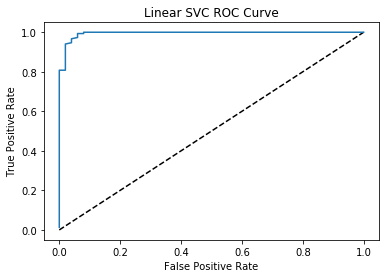

0.0 0.0132450331126
0.0 0.0596026490066
0.0 0.0728476821192
0.0 0.0927152317881
0.0 0.105960264901
0.0 0.112582781457
0.0 0.132450331126
0.0 0.139072847682
0.0 0.165562913907
0.0 0.185430463576
0.0 0.198675496689
0.0 0.278145695364
0.0 0.291390728477
0.0 0.304635761589
0.0 0.317880794702
0.0 0.324503311258
0.0 0.364238410596
0.0 0.390728476821
0.0 0.41059602649
0.0 0.423841059603
0.0 0.430463576159
0.0 0.456953642384
0.0 0.46357615894
0.0 0.490066225166
0.0 0.503311258278
0.0 0.516556291391
0.0 0.53642384106
0.0 0.562913907285
0.0 0.569536423841
0.0 0.602649006623
0.0 0.609271523179
0.0 0.635761589404
0.0 0.64238410596
0.0 0.668874172185
0.0 0.688741721854
0.0 0.701986754967
0.0 0.715231788079
0.0 0.735099337748
0.0 0.741721854305
0.0 0.761589403974
0.0 0.788079470199
0.0 0.794701986755
0.0 0.807947019868
0.02 0.807947019868
0.02 0.87417218543
0.02 0.887417218543
0.02 0.927152317881
0.02 0.940397350993
0.04 0.94701986755
0.04 0.953642384106
0.04 0.966887417219
0.06 0.973509933775
0.06 

In [24]:
plot_roc(best1.best_estimator_, X_test1, Y_test1)

## 2. PD vs MSA/PSP

In [25]:
# Get the data
data2 = group_classes(_data, {1:0, 2:1, 3:1})

y2 = data2['GroupID']
X2 = data2.drop(['GroupID'], axis=1)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=_test_size, random_state=42)

best2 = grid_search_optimization(clf, param_grid, X_train2, Y_train2, X_test2, Y_test2, cv=_cv, scoring=_scoring, verbose=1)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s


Best parameters set found on development set:

{'classifier__C': 0.26366508987303555, 'classifier__penalty': 'l1'}

Grid scores on development set:

0.702 (+/-0.005) for {'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l1'}
0.697 (+/-0.049) for {'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l2'}
0.702 (+/-0.005) for {'classifier__C': 2.3357214690901213e-05, 'classifier__penalty': 'l1'}
0.707 (+/-0.042) for {'classifier__C': 2.3357214690901213e-05, 'classifier__penalty': 'l2'}
0.702 (+/-0.005) for {'classifier__C': 5.4555947811685143e-05, 'classifier__penalty': 'l1'}
0.702 (+/-0.042) for {'classifier__C': 5.4555947811685143e-05, 'classifier__penalty': 'l2'}
0.702 (+/-0.005) for {'classifier__C': 0.00012742749857031334, 'classifier__penalty': 'l1'}
0.702 (+/-0.042) for {'classifier__C': 0.00012742749857031334, 'classifier__penalty': 'l2'}
0.702 (+/-0.005) for {'classifier__C': 0.00029763514416313193, 'classifier__penalty': 'l1'}
0.710 (+/-0.048) for {'

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    8.3s finished


In [26]:
scores = cross_validate(best2.best_estimator_, X_train2, Y_train2, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.00379948616028	0.00116557467101
score_time	0.00340051651001	0.00135638972304
test_recall	0.623865546218	0.0570998355104
train_recall	0.624251902826	0.0143472759625
test_precision	0.520322106564	0.0259865756462
train_precision	0.515033070874	0.012571969989
test_auc	0.68907821123	0.0238386380676
train_auc	0.687122647968	0.00921755806736
test_specificity	0.520322106564	0.0259865756462
train_specificity	0.515033070874	0.012571969989
test_npv	0.623865546218	0.0570998355104
train_npv	0.624251902826	0.0143472759625
test_accuracy	0.715530568049	0.0208394183937
train_accuracy	0.712493353146	0.00887435430835


In [27]:
model = best2.best_estimator_.named_steps['classifier']
feature_names = data2.columns.tolist()[1:]
# plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

UPDRS	0.962448362341


             precision    recall  f1-score   support

          0       0.82      0.70      0.76       107
          1       0.42      0.59      0.49        39

avg / total       0.72      0.67      0.69       146



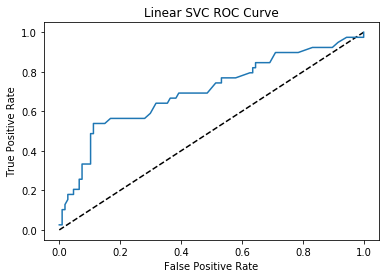

0.0 0.025641025641
0.00934579439252 0.025641025641
0.00934579439252 0.102564102564
0.018691588785 0.102564102564
0.018691588785 0.128205128205
0.0280373831776 0.153846153846
0.0280373831776 0.179487179487
0.0467289719626 0.179487179487
0.0467289719626 0.205128205128
0.0654205607477 0.205128205128
0.0654205607477 0.25641025641
0.0747663551402 0.25641025641
0.0747663551402 0.282051282051
0.0747663551402 0.333333333333
0.102803738318 0.333333333333
0.102803738318 0.384615384615
0.102803738318 0.435897435897
0.102803738318 0.487179487179
0.11214953271 0.487179487179
0.11214953271 0.538461538462
0.121495327103 0.538461538462
0.140186915888 0.538461538462
0.14953271028 0.538461538462
0.168224299065 0.564102564103
0.224299065421 0.564102564103
0.233644859813 0.564102564103
0.252336448598 0.564102564103
0.280373831776 0.564102564103
0.299065420561 0.589743589744
0.317757009346 0.641025641026
0.327102803738 0.641025641026
0.345794392523 0.641025641026
0.355140186916 0.641025641026
0.36448598130

In [28]:
plot_roc(best2.best_estimator_, X_test2, Y_test2)

## 3. MSA vs PD/PSP

In [47]:
# Get the data
data3 = group_classes(_data, {1:0, 3:0, 2:1})

y3 = data3['GroupID']
X3 = data3.drop(['GroupID'], axis=1)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, y3, test_size=_test_size, random_state=42)

best3 = grid_search_optimization(clf, param_grid, X_train3, Y_train3, X_test3, Y_test3, cv=_cv, scoring=_scoring, verbose=1)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s


Best parameters set found on development set:

{'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l1'}

Grid scores on development set:

0.878 (+/-0.006) for {'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l1'}
0.126 (+/-0.008) for {'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l2'}
0.878 (+/-0.006) for {'classifier__C': 6.1584821106602672e-05, 'classifier__penalty': 'l1'}
0.126 (+/-0.008) for {'classifier__C': 6.1584821106602672e-05, 'classifier__penalty': 'l2'}
0.878 (+/-0.006) for {'classifier__C': 0.00037926901907322499, 'classifier__penalty': 'l1'}
0.126 (+/-0.008) for {'classifier__C': 0.00037926901907322499, 'classifier__penalty': 'l2'}
0.878 (+/-0.006) for {'classifier__C': 0.0023357214690901212, 'classifier__penalty': 'l1'}
0.126 (+/-0.008) for {'classifier__C': 0.0023357214690901212, 'classifier__penalty': 'l2'}
0.878 (+/-0.006) for {'classifier__C': 0.01438449888287663, 'classifier__penalty': 'l1'}
0.126 (+/-0.008) for {'cl

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.6s finished
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in longlong_scalars


In [48]:
scores = cross_validate(best3.best_estimator_, X_train3, Y_train3, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0027144908905	0.000398766334301
score_time	0.00429539680481	0.000395912163822
test_recall	0.0	0.0
train_recall	0.0	0.0
test_precision	0.0	0.0
train_precision	0.0	0.0
test_auc	0.5	0.0
train_auc	0.5	0.0
test_specificity	nan	nan
train_specificity	nan	nan
test_npv	0.0	0.0
train_npv	0.0	0.0
test_accuracy	0.877597355169	0.00292957557924
train_accuracy	0.877586909621	0.00073850541077


C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and bein

In [31]:
model = best3.best_estimator_.named_steps['classifier']
feature_names = data3.columns.tolist()[1:]
# plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

UPDRS	0.0


C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.92      1.00      0.96       134
          1       0.00      0.00      0.00        12

avg / total       0.84      0.92      0.88       146



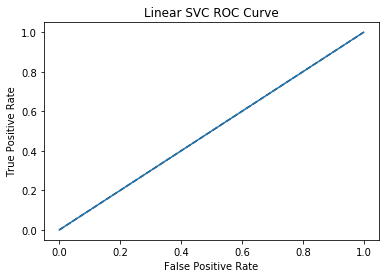

0.0 0.0
1.0 1.0


In [32]:
plot_roc(best3.best_estimator_, X_test3, Y_test3)

## 4. PSP vs PD/MSA

In [33]:
# Get the data
data4 = group_classes(_data, {1:0, 2:0, 3:1})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=42)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring, verbose=1)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.4s


Best parameters set found on development set:

{'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l1'}

Grid scores on development set:

0.824 (+/-0.006) for {'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l1'}
0.619 (+/-0.108) for {'classifier__C': 1.0000000000000001e-05, 'classifier__penalty': 'l2'}
0.824 (+/-0.006) for {'classifier__C': 2.3357214690901213e-05, 'classifier__penalty': 'l1'}
0.624 (+/-0.108) for {'classifier__C': 2.3357214690901213e-05, 'classifier__penalty': 'l2'}
0.824 (+/-0.006) for {'classifier__C': 5.4555947811685143e-05, 'classifier__penalty': 'l1'}
0.617 (+/-0.107) for {'classifier__C': 5.4555947811685143e-05, 'classifier__penalty': 'l2'}
0.824 (+/-0.006) for {'classifier__C': 0.00012742749857031334, 'classifier__penalty': 'l1'}
0.624 (+/-0.099) for {'classifier__C': 0.00012742749857031334, 'classifier__penalty': 'l2'}
0.824 (+/-0.006) for {'classifier__C': 0.00029763514416313193, 'classifier__penalty': 'l1'}
0.628 (+/-0.107) for

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.6s finished
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in longlong_scalars


In [34]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.00351099967957	0.00141692902048
score_time	0.00430092811584	0.00139980341339
test_recall	0.0	0.0
train_recall	0.0	0.0
test_precision	0.0	0.0
train_precision	0.0	0.0
test_auc	0.5	0.0
train_auc	0.5	0.0
test_specificity	nan	nan
train_specificity	nan	nan
test_npv	0.0	0.0
train_npv	0.0	0.0
test_accuracy	0.824157152193	0.0030255251592
train_accuracy	0.824139136277	0.000759761198481


C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and bein

In [35]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
# plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

UPDRS	0.0


C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.82      1.00      0.90       119
          1       0.00      0.00      0.00        27

avg / total       0.66      0.82      0.73       146



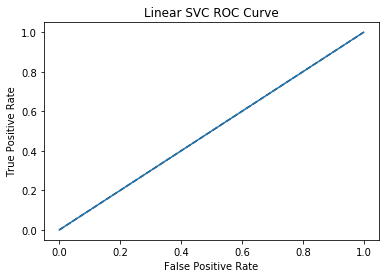

0.0 0.0
1.0 1.0


In [36]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)